In [1]:
import sandbox_assets as sa
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit import QuantumCircuit, transpile
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error, phase_damping_error,amplitude_damping_error )

In [2]:
seed = 1

#### Redefine the `cswap()`, `h()` gates to the $\text{CX, RZ, ID, SX, X}$ basis gates. 

In [3]:
cswap_qc = QuantumCircuit(3, name = 'cswap_t')
cswap_qc.cswap(0,1,2)

cswap_t = transpile(cswap_qc, basis_gates = ['cx', 'rz', 'id', 'sx', 'x'], optimization_level = 3, seed_transpiler = seed)

#cswap_t.draw() # uncomment to draw

/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [4]:
h_t_qc = QuantumCircuit(1, name = 'h_t')
h_t_qc.rz(np.pi/2, 0)
h_t_qc.sx(0)
h_t_qc.rz(np.pi/2, 0)

h_t = h_t_qc.to_instruction()

#### Redefine the `GHZ()`, `derangement()` and `circassembler()` functions to use the new `cswap_t()` and `h_t()` gates.

In [5]:
def GHZ_t(qc):

    registers = qc.qregs[:0:-1]
    numQubits = registers[0].size

    for reg in registers:
        qc.append(h_t, [reg[0]])

        for qubit in range(numQubits-1):
            qc.cnot(reg[qubit], reg[qubit+1])

In [6]:
sa.GHZ = GHZ_t

In [7]:
def derangement_t(qc):
    
    ancilla_qubit = qc.ancillas[0]
    registers = qc.qregs[1:]
    numQubits = registers[0].size

    for i in reversed(range(1, len(registers))):
        for j in reversed(range(numQubits)):
            qc.append(cswap_t,(ancilla_qubit, registers[i][j], registers[i-1][j]))


In [8]:
sa.derangement = derangement_t

In [9]:
def circ_assembler_t(numReg, numQ, numAnc, sigma, basis_gates, seed = 1, der_op = True):

    qc = sa.iniQC(numReg, numQ, numAnc)
    sa.GHZ(qc)
    qc.barrier()
    qc.append(h_t, [0])
    if der_op == True:
        sa.derangement(qc)
        qc.barrier()
    if sigma != False: 
        qc = sa.observable(sigma = sigma, qc = qc, basis_gates = basis_gates, seed = seed)
    qc.append(h_t, [0])

    return(qc)


In [10]:
sa.circ_assembler = circ_assembler_t

## Fake noise models:

In [52]:
from qiskit.providers.fake_provider import FakeProvider

First we look at the available fake backends and filter them by two criteria:

1. They must have the basis gates: $\text{CX, RZ, ID, SX, X}$.
2. They must have at least 11 qubits.

In [145]:

basis_gates = ['id', 'rz', 'sx', 'x', 'cx']
compatible_backends = []

for backend in FakeProvider().backends():
    config = backend.configuration()
    if (all(gate in config.basis_gates for gate in basis_gates) and config.n_qubits >= 11):
        compatible_backends.append(backend)

Next we create a dictionary containing the name of the compatible backends associated with their noise models. We are not interested in the readout error.

In [151]:
noise_models = {backend.configuration().backend_name : NoiseModel.from_backend(backend, readout_error=False, 
                                                                               thermal_relaxation=True, gate_error=True) for backend in compatible_backends}

We set up two new dictionaries that will contain the expectation value of our circuits assoiciated with the different backends.

In [152]:
mit_expectation_values = {backend.configuration().backend_name : 0 for backend in compatible_backends}
unmit_expectation_values = {backend.configuration().backend_name : 0 for backend in compatible_backends}

Setup our observable, 5 $X$ paulis:

In [103]:
obs = QuantumCircuit(5)
obs.x(range(5))
#obs.draw(style = "default")

Exact simulation:

In [154]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = None # we are interested in the exact (algeabraic) expectation value hence no shots


for i in tqdm(noise_models):

    noise_model = noise_models[i]

    mit_exp, unmit_exp = sa.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_model,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    
    mit_expectation_values[i] = mit_exp
    unmit_expectation_values[i] = unmit_exp

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
100%|██████████| 12/12 [00:36<00:00,  3.07s/it]


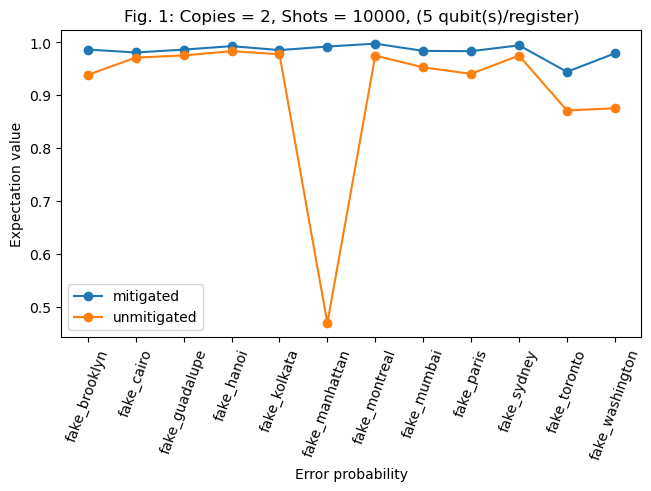

In [183]:

fig, ax = plt.subplots(layout = 'constrained')

ax.plot(mit_expectation_values.keys(), mit_expectation_values.values(), marker = "o", label = "mitigated")
ax.plot(unmit_expectation_values.keys(), unmit_expectation_values.values(),  marker = "o", label = "unmitigated")
ax.legend()
ax.set(
       title ='Fig. 1: Copies = {}, Shots = {}, ({} qubit(s)/register)'.format(copies, nb_shots, qubits),
       xlabel = 'Error probability', 
       ylabel = 'Expectation value',
)
ax.tick_params('x', labelrotation=70)

plt.show()

Interesting behaviour for 'fake_manhattan'! Also great news, for all cases the mitigated circuit performed better than the unmitigated one.

Next we create new dictionaries for the shot based simulations. First we look at 1000 then at 10000 shots.

In [157]:
mit_expectation_values_1k = {backend.configuration().backend_name : 0 for backend in compatible_backends}
unmit_expectation_values_1k = {backend.configuration().backend_name : 0 for backend in compatible_backends}

mit_expectation_values_10k = {backend.configuration().backend_name : 0 for backend in compatible_backends}
unmit_expectation_values_10k = {backend.configuration().backend_name : 0 for backend in compatible_backends}

In [160]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = 1000


for i in tqdm(noise_models):

    noise_model = noise_models[i]

    mit_exp, unmit_exp = sa.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_model,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    
    mit_expectation_values_1k[i] = mit_exp
    unmit_expectation_values_1k[i] = unmit_exp

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:36<00:00,  3.04s/it]


In [167]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = 10000


for i in tqdm(noise_models):

    noise_model = noise_models[i]

    mit_exp, unmit_exp = sa.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_model,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    
    mit_expectation_values_10k[i] = mit_exp
    unmit_expectation_values_10k[i] = unmit_exp

100%|██████████| 12/12 [00:32<00:00,  2.74s/it]


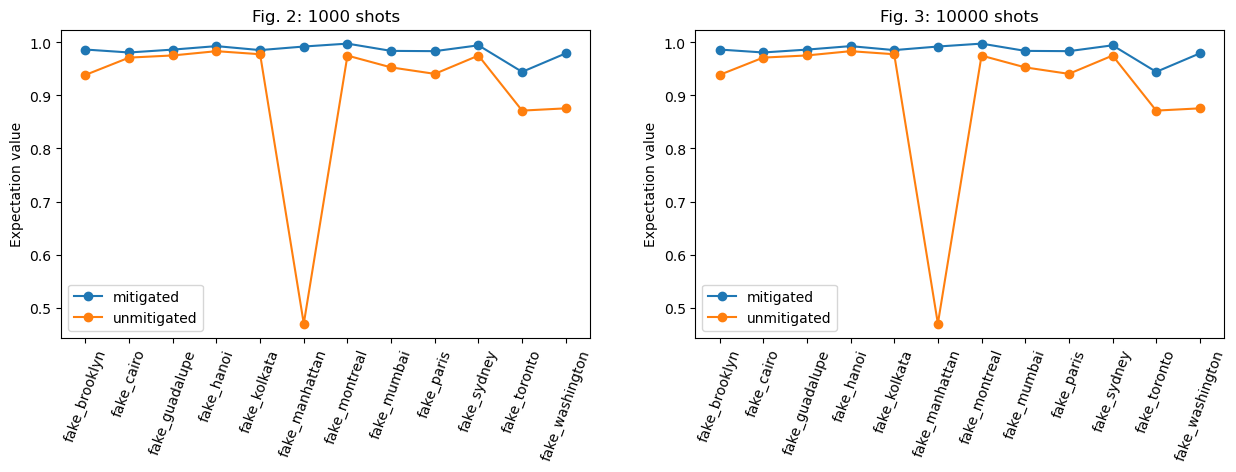

In [182]:

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15, 4))

ax1.plot(mit_expectation_values_1k.keys(), mit_expectation_values.values(), marker = "o", label = "mitigated")
ax1.plot(unmit_expectation_values_1k.keys(), unmit_expectation_values.values(),  marker = "o", label = "unmitigated")

ax1.legend()
ax1.set(
       title ='Fig. 2: 1000 shots',
       ylabel = 'Expectation value',
)

ax1.tick_params('x', labelrotation=70)

ax2.plot(mit_expectation_values_10k.keys(), mit_expectation_values.values(), marker = "o", label = "mitigated")
ax2.plot(unmit_expectation_values_10k.keys(), unmit_expectation_values.values(),  marker = "o", label = "unmitigated")

ax2.legend()
ax2.set(
       title ='Fig. 3: 10000 shots',
       ylabel = 'Expectation value',
)

ax2.tick_params('x', labelrotation=70)

plt.show()